Try to compute DCR for a given SED.

First, we'll use the code that generates Figure 2 in the paper.

Let's tweak it so we can try to use the supernova spectrum.

This is a mod. of chroma_test2 where we're going to play with estimating the DCR for a SN Ia along its light curve.

In [27]:
import os
import numpy as np

#import dcr
import spec
#import plot
#import utils

#import _mypath
#import chroma

datadir = './chroma/data/'

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

## see http://matplotlib.org/users/colormaps.html for colormaps
from matplotlib import cm

In [29]:
import pandas as pd

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [ ]:
from scipy.interpolate import interp1d

tmp,w,f = np.genfromtxt('./chroma/data/SEDs/snflux_1a.dat').T
w /= 10. ## convert from angstroms to nm?
ss = interp1d(w, f)

sn_SED = spec.SED(ss)
wave = np.arange(500.0, 901.0, 1.0)
photons = sn_SED(wave)

plt.plot(ss.x, ss.y)

Aha, the SN Ia spec is multiple spectra - let's extract all of them and set to $z=0.5$ (first few look weird).

In [21]:
#print np.where(w == w.max())[0]
sn_SEDs = []
val_prev = 0
for ind,val in enumerate(np.where(w == w.max())[0]):
    #print ind,val
    ww = w[val_prev:val]
    ff = f[val_prev:val]
    ss = interp1d(ww, ff)
    sed = spec.SED(ss).atRedshift(0.5)
    sn_SEDs.append(sed)
    val_prev = val + 1

print len(sn_SEDs) 
#plt.plot(w[252105:254506], f[252105:254506])

106


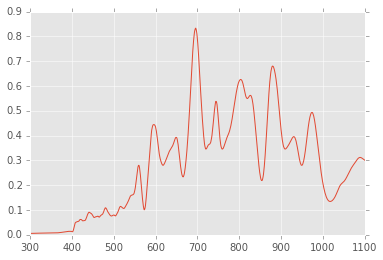

In [47]:
sn_SED = sn_SEDs[100] #spec.SED(ss).atRedshift(0.5)
wave = np.arange(300.0, 1101.0, 1.0)
photons = sn_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 900)].max()
plt.plot(wave, photons/scale)

Looks like spec has a few useful functions like 

```
calculateDCRMomentShifts(self, bandpass, **kwargs):
```

        @returns a tuple.  The first element is the vector of DCR first moment shifts, and the
                 second element is the 2x2 matrix of DCR second (central) moment shifts.


Sa galaxy at redshift 0.5

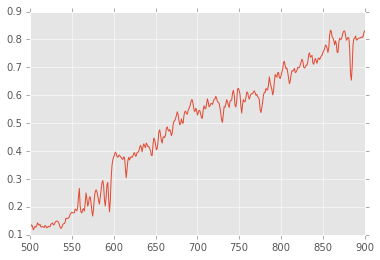

In [50]:
#gal_SED = spec.SED(datadir+'/SEDs/'+'KIN_Sa_ext.ascii')
w,f = np.genfromtxt('./chroma/data/SEDs/KIN_Sa_ext.ascii').T
#toAppend = np.arange(w.max()+0.5,1200.,0.5)
#w = np.append(w, toAppend)
#f = np.append(f, np.zeros_like(toAppend))
ss = interp1d(w, f)

gal_SED = spec.SED(ss).atRedshift(0.5)
wave = np.arange(500.0, 901.0, 1.0)
photons = gal_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 1000)].max()
plt.plot(wave, photons/scale)

Make a relative DCR curve for SN Ia along its light curve (assume ZD angle 20 deg.)

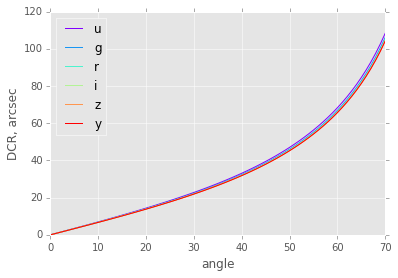

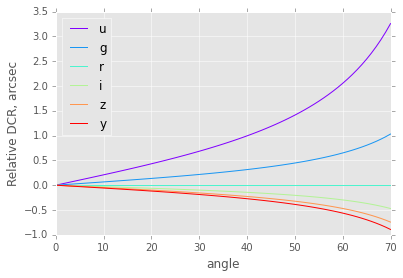

In [76]:
# filters are stored in two columns: wavelength (nm), and throughput

def compute_dcr(SED, filters='ugrizy', angles=np.linspace(0,70,71), relative=None):
    if type(angles) is int or type(angles) is float:
        angles = np.array([angles])
    elif type(angles) is list:
        angles = np.array(angles)
    df = pd.DataFrame(pd.Series(angles)) #, index=pd.Series(angles))
    for i, filter_ in enumerate(filters):
        fdata = spec.Bandpass(datadir+'filters/LSST_{}.dat'.format(filter_))
        fwave, throughput = fdata.wave_list, fdata(fdata.wave_list)
        shifts = np.array( [SED.calculateDCRMomentShifts(fdata, zenith_angle=angle * np.pi/180.0)[0].item(1) 
                        for angle in angles])
        shifts = shifts * 3600.0 * 180.0/np.pi
        df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
    df.columns = np.insert(np.array(list('ugrizy'), dtype='S6'), 0, 'angle')
    df = df.set_index('angle')
    if relative is not None and np.any(df.columns.values == relative):
        df2 = df.copy().sub(df[relative], axis=0)
        return df2
    else:
        return df

angles = np.linspace(0,70,71)

DCRs = compute_dcr(sn_SED, 'ugrizy', angles)
ax = DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('DCR, arcsec')

DCRs = compute_dcr(sn_SED, 'ugrizy', angles, relative='r')
ax = DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative DCR, arcsec')

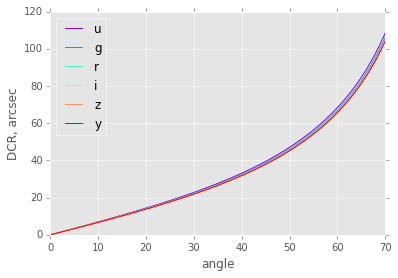

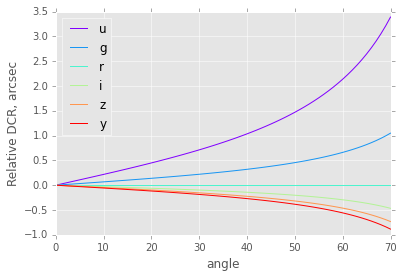

In [66]:
DCRs_gal = compute_dcr(gal_SED, 'ugrizy', angles)
ax = DCRs_gal.plot(colormap=cm.rainbow)
ax.set_ylabel('DCR, arcsec')

DCRs_gal = compute_dcr(gal_SED, 'ugrizy', angles, relative='r')
ax = DCRs_gal.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative DCR, arcsec')

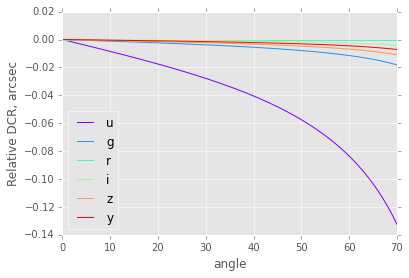

In [67]:
df_tmp = DCRs - DCRs_gal
sizeme(df_tmp.head())
ax = df_tmp.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative DCR, arcsec')

In [93]:
sizeme(compute_dcr(sn_SED, 'ugrizy', 20.))

,u,g,r,i,z,y
angle,,,,,,
20,14.356802,14.06186,13.925262,13.862969,13.826746,13.807054


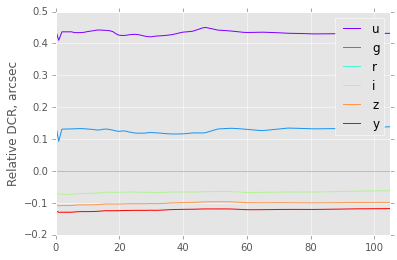

In [92]:
sn_DCRs = pd.concat([compute_dcr(SED, 'ugrizy', 20., relative='r') for SED in sn_SEDs])
sn_DCRs = sn_DCRs.set_index(np.arange(len(sn_SEDs)))
ax = sn_DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative DCR, arcsec')
#sizeme(sn_DCRs)